In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
#%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = (12, 8) # set default figure size, 8in by 6in

# 7. (Chapter 7) Ensemble Learning

Sometimes aggregrates or ensembles of many different opinions on a question can perform as well or better than asking
a single expert on the same question.  This is known as the *wisdom of the crowd* when the aggregrate opinion of
people on a question performs as well or better as a single isolated expert in predicting some outcome.

Likewise, for machine learning predictors, a similar effect can also often occur.  The aggregrate performance of
multiple predictors and often make a small but significant improvement on building a classifier or regression
predictor for a complex set of data.  A group of machine learning predictors is called an *ensemble*, and thus
this technique of combining the predictions of an ensemble is known as *Ensemble Learning* . 

For exampl,e we could train a group of Decision Tree classifiers, each on a different random subset of the training
data.  To make an ensemble prediciton, you just obtain the predictions of all individual trees, then predict the
class that gets the most votes.  Such an ensemble of Decision Trees is called a *Random Forest*, and despite the
relative simplicity of decision tree predictors, it can be surprisingly powerful as a ML predictor.

## 7.1 Voting Classifiers

Say you have several classifiers for the same classification problem (say a Logistic Classifier, and SVM,
a Decision Tree and a KNN classifier and perhaps a few more).  The simplest way to create an ensemble classifier
is to aggregrate the predictions of each classifier and predict the class that gets the most votes.  This
majority-vote classifier is called a *hard voting* classifier.

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the
ensemble.  In fact, even if each classifier is a *weak learner* (meaning it only does slightly better than
random guessing), the ensemble can still be a *strong learner* (achieving high accuracy).  The key to making
good ensemble predictors is that you need both a sufficient number of learners (even of weak learners), but
also maybe more importantly, the learners need to be "sufficiently diverse", where diverse is a bit fuzzy to
define, but in general the classifiers must be as independent as possible, so that even if they are weak predictors,
they are weak in different and diverse ways.



In [3]:
def flip_unfair_coin(num_flips, head_ratio):
    """Simulate flipping an unbalanced coin.  We return a numpy array of size num_flips, with 0 to represent
    1 to represent a head and 0 a tail flip.  We generate a head or tail result using the head_ratio probability
    threshold drawn from a standard uniform distribution.    
    """
    # array of correct size to hold resulting simulated flips
    flips = np.empty(num_flips)
    
    # flip the coin the number of indicated times
    for flip in range(num_flips):
        flips[flip] = np.random.random() < head_ratio
        
    # return the resulting coin flip trials trials
    return flips

def running_heads_ratio(flips):
    """Given a sequence of flips, where 1 represents a "Head" and 0 a "Tail" flip, return an array
    of the running ratio of heads / tails
    """
    # array of correct size to hold resulting heads ratio seen at each point in the flips sequence
    num_flips = flips.shape[0]
    head_ratios = np.empty(num_flips)
    
    # keep track of number of heads seen so far, the ratio is num_heads / num_flips
    num_heads = 0.0
    
    # calculate ratio for each flips instance in the sequence
    for flip in range(num_flips):
        num_heads += flips[flip]
        head_ratios[flip] = num_heads / (flip + 1)
        
    # return the resulting sequence of head ratios seen in the flips
    return head_ratios

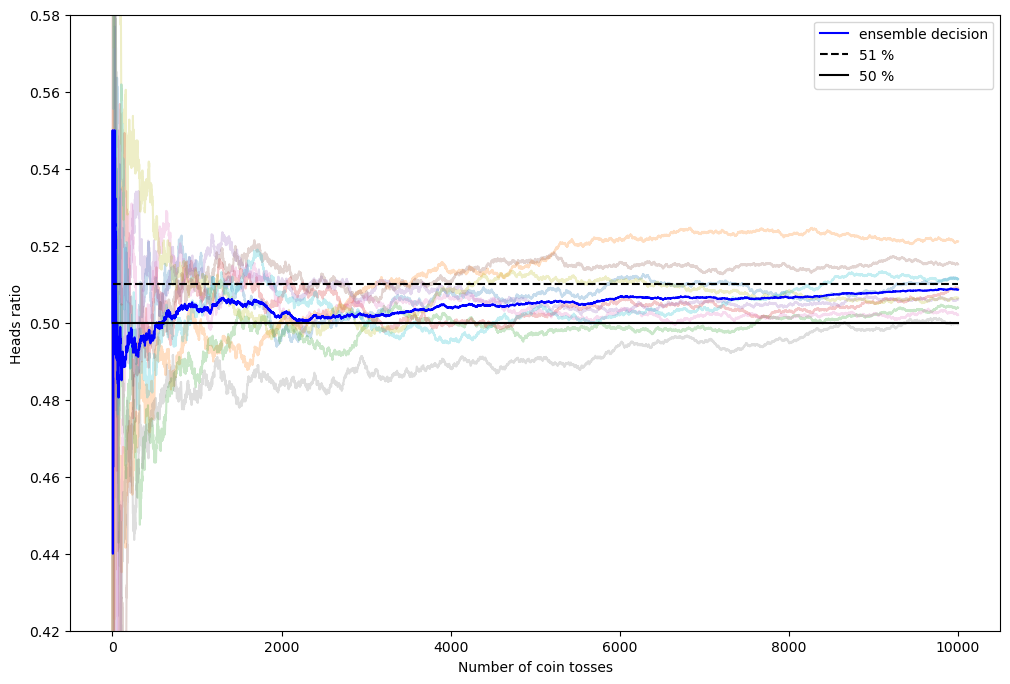

In [4]:
NUM_FLIPPERS = 10
NUM_FLIPS = 10000
HEAD_PERCENT = 0.51

# create 3 separate sequences of flippers
flippers = np.empty( (NUM_FLIPPERS, NUM_FLIPS) )
for flipper in range(NUM_FLIPPERS):
    flips = flip_unfair_coin(NUM_FLIPS, HEAD_PERCENT)
    head_ratios = running_heads_ratio(flips)
    flippers[flipper] = head_ratios
    
# create an ensemble, in this case we will average the individual flippers
ensemble = flippers.mean(axis=0)

# plot the resulting head ratio for our flippers
flips = np.arange(1, NUM_FLIPS+1)
for flipper in range(NUM_FLIPPERS):
    plt.plot(flips, flippers[flipper], alpha=0.25)
plt.plot(flips, ensemble, 'b-', alpha=1.0, label='ensemble decision')
plt.ylim([0.42, 0.58])
plt.plot([1, NUM_FLIPS], [HEAD_PERCENT, HEAD_PERCENT], 'k--', label='51 %')
plt.plot([1, NUM_FLIPS], [0.5, 0.5], 'k-', label='50 %')
plt.xlabel('Number of coin tosses')
plt.ylabel('Heads ratio')
plt.legend();

### Scikit-Learn Voting Classifier

The following code is an example of creating a voting classifier in Scikit-Learn.  We are using the moons dataset
shown.

Here we create 3 separate classifiers by hand, a logistic regressor, a decision tree,
and a support vector classifier (SVC).  Notice we specify  'hard' voting for the voting classifier, which
as we discussed is the simple method of choosing the class with the most votes.
(This is a binary classification so 2 out of 3 or 3 out of 3 are the only possibilities.  For a multiclass
classification, in case of a tie vote, the voting classifier may fall back to the probability scores the
classifiers give, assuming the provide probability/confidence measures of their prediction).

In [5]:
# helper functions to visualize decision boundaries for 2-feature classification tasks

# create a scatter plot of the artificial multiclass dataset
from matplotlib import cm

# visualize the blobs using matplotlib.  An example of a funciton we can reuse, since later
# we want to plot the decision boundaries along with the scatter plot data
def plot_multiclass_data(X, y):
    """Create a scatter plot of a set of multiclass data.  We assume that X has 2 features so that
    we can plot on a 2D grid, and that y are integer labels [0,1,2,...] with a unique integer
    label for each class of the dataset.
    
    Parameters
    ----------
    X - A (m,2) shaped number array of m samples each with 2 features
    y - A (m,) shaped vector of integers with the labeled classes of each of the X input features
    """
    # hardcoded to handle only up to 8 classes
    markers = ['o', '^', 's', 'd', '*', 'p', 'P', 'v']
    #colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    
    # determine number of features in the data
    m = X.shape[0]
    
    # determine the class labels
    labels = np.unique(y)
    #colors = cm.rainbow(np.linspace(0.0, 1.0, labels.size))
    colors = cm.Set1.colors
    
    # loop to plot each
    for label, marker, color in zip(labels, markers, colors):
        X_label = X[y == label]
        y_label = y[y == label]
        label_text = 'Class %s' % label
        plt.plot(X_label[:,0], X_label[:,1], 
                 marker=marker, markersize=8.0, markeredgecolor='k',
                 color=color, alpha=0.25, 
                 linestyle='',
                 label=label_text)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend();
    
    
def plot_multiclass_decision_boundaries(model, X, y):
    from matplotlib.colors import ListedColormap
    """Use a mesh/grid to create a contour plot that will show the decision boundaries reached by
    a trained scikit-learn classifier.  We expect that the model passed in is a trained scikit-learn
    classifier that supports/implements a predict() method, that will return predictions for the
    given set of X data.
    
    Parameters
    ----------
    model - A trained scikit-learn classifier that supports prediction using a predict() method
    X - A (m,2) shaped number array of m samples each with 2 features
    """
    # determine the class labels
    labels = np.unique(y)
    #colors = cm.rainbow(np.linspace(0.0, 1.0, labels.size))
    #colors = cm.Set1.colors
    newcmp = ListedColormap(plt.cm.Set1.colors[:len(labels)])
    
    # create the mesh of points to use for the contour plot
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - h, X[:, 0].max() + h
    y_min, y_max = X[:, 1].min() - h, X[:, 1].max() + h

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # create the predictions over the mesh using the trained models predict() function
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Create the actual contour plot, which will show the decision boundaries
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=newcmp, alpha=0.33)
    #plt.colorbar()

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=2500, noise=0.3)

# we will split data using a 75%/25% train/test split this time
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='lbfgs', C=5.0)
tree_clf = DecisionTreeClassifier(max_depth=10)
svm_clf = SVC(gamma=100.0, C=1.0)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('tree', tree_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=5.0)),
                             ('tree', DecisionTreeClassifier(max_depth=10)),
                             ('svc', SVC(gamma=100.0))])

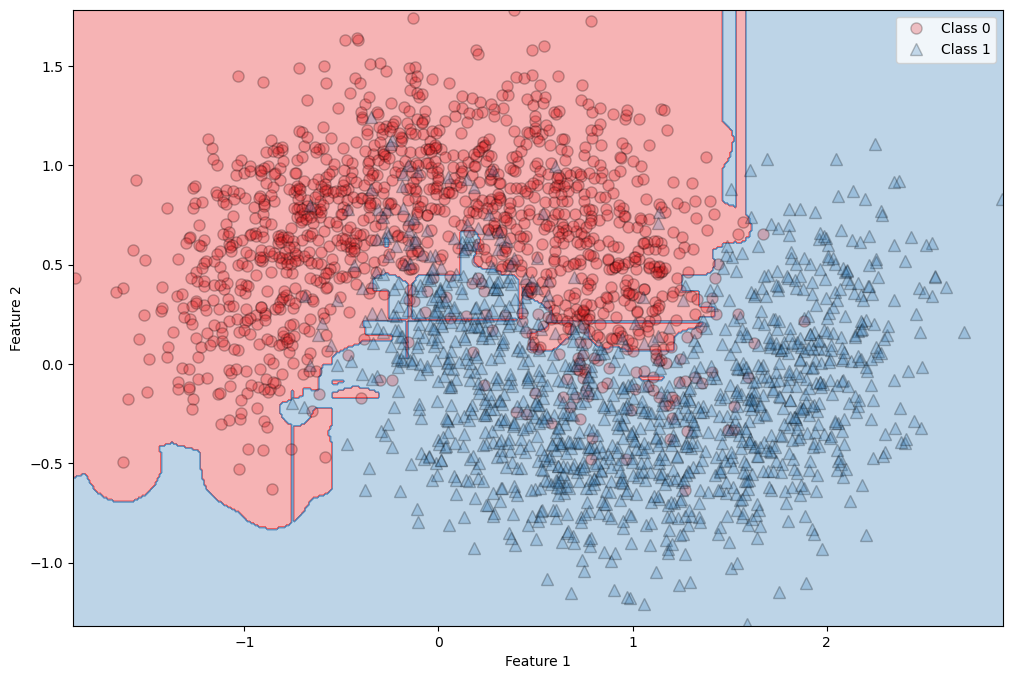

In [8]:
plot_multiclass_decision_boundaries(voting_clf, X, y)
plot_multiclass_data(X, y)

Lets look at each classifier's accuracy on the test set, including for the ensemble voting classifier:

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8352
DecisionTreeClassifier 0.8672
SVC 0.9008
VotingClassifier 0.8928


The voting classifier will usually outperform all the individual classifier, if the data is sufficiently
nonseparable to make it relatively hard (e.g. with less random noise in the moons data set, you can get
real good performance sometimes with random forest and/or svc, which will exceed the voting classifier).

If all classifiers are able to estimate class probabilities (i.e. in `scikit-learn` they support
`predict_proba()` method), then you can tell `scikit-learn` to predict the class with the highest class
probability, averaged over all individual classifiers.  You can think of this as each classifier having
its vote weighted by its confidence of the prediction.  This is called *soft voting*.  It often achieves
higher performance than hard voting because it gives more weight to highly confident votes.  All you
need to do is replace `voting='hard'` with `voting='soft'` and ensure that all classifiers can estimate
clas sprobabilities.  If you recall, support vector machine classifiers (`SVC`) do not estimate class probabilities by
default, but if you set `SVC` `probability` hyperparameter to `True`, the `SVC` class will use cross-validation
to estimate class probabilities.  This slows training, but it makes the `predict_proba()` method valid
for `SVC`, and since both logistic regression and random forests support this confidence estimate, we
can then use soft voting for the voting classifier.  

In [10]:
log_clf = LogisticRegression(solver='lbfgs', C=5.0)
tree_clf = DecisionTreeClassifier(max_depth=8)
svm_clf = SVC(gamma=1000.0, C=1.0, probability=True) # enable probability estimates for svm classifier

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('tree', tree_clf), ('svc', svm_clf)],
    voting='soft'  # use soft voting this time
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=5.0)),
                             ('tree', DecisionTreeClassifier(max_depth=8)),
                             ('svc', SVC(gamma=1000.0, probability=True))],
                 voting='soft')

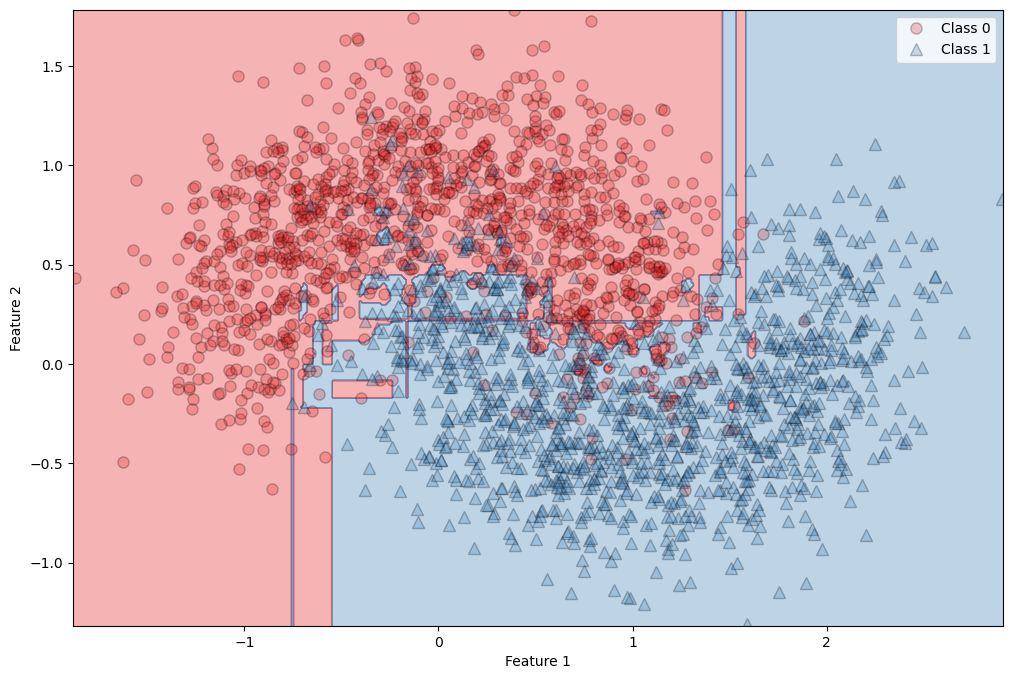

In [11]:
plot_multiclass_decision_boundaries(voting_clf, X, y)
plot_multiclass_data(X, y)

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8352
DecisionTreeClassifier 0.888
SVC 0.848
VotingClassifier 0.8816


## 7.2 Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms.  The previous voting
classifier was an example of this, where we used 3 very different kinds of classifiers for the voting ensemble.

Another approach is to use the same training for every predictor, but to train them on different random
subsets of the training set.  When sampling is performed with replacement, this method is called
*bagging* (short for *bootstrap aggregrating*).  When sampling is performed without replacement, it is
called *pasting*.

In other words, both approaches are similar.  In both cases you are sampling the training data to build
multiple instances of a classifier.  In both cases a training item could be sampled and used to train
multiple instances in the collection of classifiers that is produced.  In bagging, it is possible for a training
sample to be sampled multiple times in the training for the same predictor.  This type of bootstrap aggregration
is a type of data enhancement, and it is used in other contexts as well in ML to artificially increase the size
of the training set.

Once all predictors are trained, the ensemble can make predictions for a new instance by simply aggregating the
predictions of all the predictors.  The aggregration function is typically the *statistical mode* (i.e. the
most frequent prediction, just like hard voting) for classification, or the average for regression.

Each individual predictor has a higher bias than if it were trained on the original training set (because you don't
use all of the training data on an individual bagged/pasted classifier).  But the aggregration overall should usually
reduce both bias and variance on the final performance.  Generall the net result is that the ensemble has a similar
bias but a lower variance than a single predictor trained on the whole original training set.

Computationally bagging and pasting are very attractive because in theory and in practice all of the classifiers
can be trained in parallel.  Thus if you have a large number of CPU cores, or even a distributed memory
computing cluster, you can independently train the individual classifiers all in parallel.

### Scikit-Learn Bagging and Pasting Examples

The ensemble API in `scikit-learn` for performing bagging and/or pasting is relatively simple.  As with the voting
classifier, we specify which type of classifer we want to use.  But since bagging/pasting train multiple
classifiers all of this type, we only have to specify 1.  The `n_jobs` parameter tells `scikit-learn` the number of
cpu cores to use for training and predictions (-1 tells `scikit-learn` to use all available cores).

The following trains an ensemble of 500 decision tree classifiers (`n_estimators`), each trained on 100 training
instances randomly sampled from the training set with replacement (`bootstrap=True`).  If you want to use pasting
we simply set `bootstrap=False` instead.

**NOTE**: The `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier
can estimate class probabilities (i.e. it has a `predict_proba()` method).

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=20), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.9056


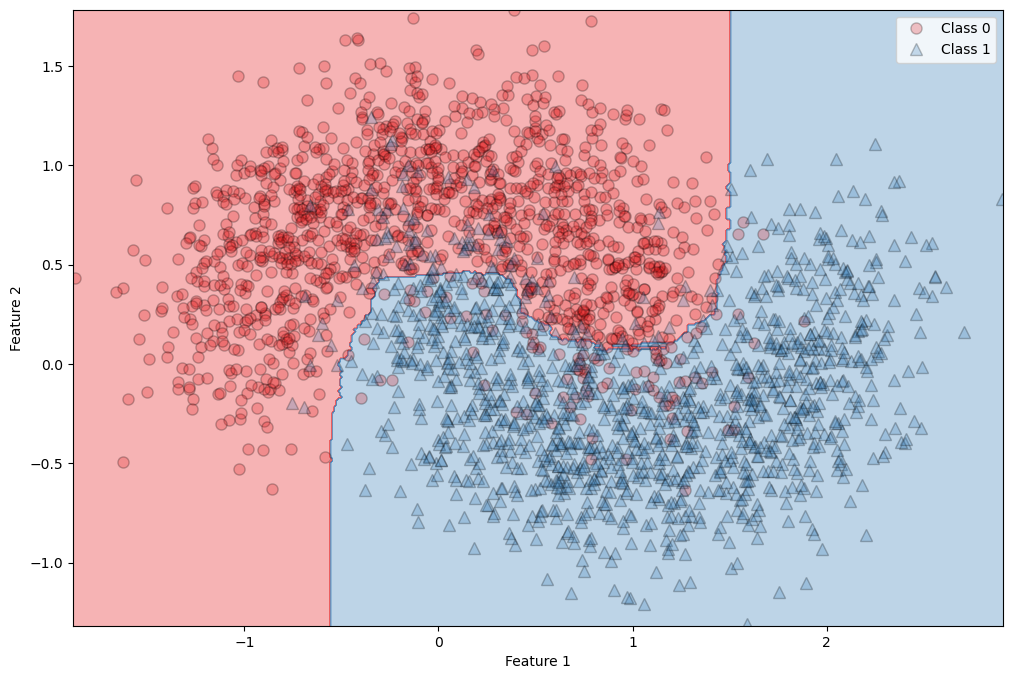

In [14]:
plot_multiclass_decision_boundaries(bag_clf, X, y)
plot_multiclass_data(X, y)

In [15]:
# example decision boundary from single decision tree instead
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.8576


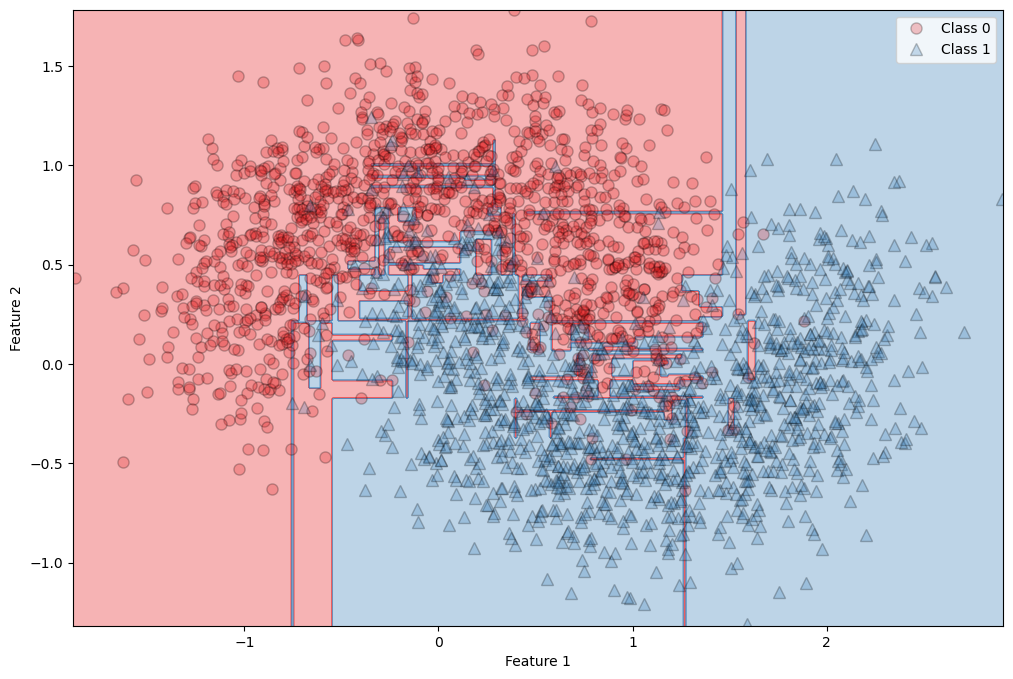

In [16]:
plot_multiclass_decision_boundaries(tree_clf, X, y)
plot_multiclass_data(X, y)

These figures compare the decision boundary of a single Decision Tree with the decision
boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on
the moons dataset. As you can see, the ensemble’s predictions will likely generalize
much better than the single Decision Tree’s predictions: the ensemble has a comparable
bias but a smaller variance (it makes roughly the same number of errors on the training
set, but the decision boundary is less irregular).

### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be
sampled at all.  By default a `BaggingClassifier` samples `m` training instances with replacement, where `m`
is the size of the training set.  This means that only about 63% of the training instances are sampled on average for
each predictor.  The remaining 37% of the training instances that are not sampled are called *out-of-bag* (oob)
instances.  **NOTE**: they are not the same 37% for each resulting predictor, each predictor has a different oob.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need
for a separate validation set or cross-validation.  You can evaluate the ensemble itself by averaging out the oob
evaluations for each predictor.

In `scikit-learn` you can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic oob
evaluation after training:

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.896
0.8784


The oob decision function for each training instance is also available through the
`oob_decision_function_` variable.  

In [18]:
bag_clf.oob_decision_function_

array([[0.77595628, 0.22404372],
       [0.985     , 0.015     ],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.98412698, 0.01587302],
       [1.        , 0.        ]])

## 7.3 Random Patches and Random Subspaces

The default behavior of the bagging/patching classifier is to only sample the training target outputs.  However,
it can also be useful to build classifiers that only use some of the feautres of the input data.  We have looked
at methods for adding features, for example by adding polynomial combinations of the feature inputs.  But often for
big data, we might have thousands or even millions of input features. In that case, it can very well be that some
or many of the features are not really all that useful, or even somewhat harmful, to building a truly good and
general classifier.

So one approach when we have large number of features is to build multiple classifiers (using bagging/patching)
on sampled subsets of the features.  In `scikit-learn` `BaggingClassifier` this is controllerd by two
hyperparameters: `max_features` and `bootstrap_features`.  They work the same as `max_samples` and `bootstrap`
but for feature sampling instead of output instance sampling.  Thus each predictor will be trained on a random subset
of the input features. This is particularly useful when dealing with high-dimensional inputs.  

Sampling from both training instances and features simultaneously is called the *Random Patches method*.
Keeping all training instances, but sampling features is called *Random Subspaces method*.

## 7.4 Random Forests

As we have already mentioned, a `RandomForest` is simply an ensemble of decision trees, generally trained via the
bagging method, typically with `max_samples` set to the size of the training set.  We could create a
random forest by hand using `scikit-learn` `BaggingClassifier` on a DecisionTree, which is in fact what we just
did in the previous section.  Our previous ensemble was an example of a random forest classifier.

But in `scikit-learn` instead of building the ensemble somewhat by hant, you can instead use the
`RandomForestClassifier` class, which is more convenient and which has default hyperparameter settings
optimized for random forests.

The following code trains a random forest classifier with 500 treas (each limited to a maximum of 16 nodes),
using all available CPU cores:

In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9056


A random forest classifier has all of the hyperparameters of a `DecisionTreeClassifier` (to control
how trees are grown), plus all of the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The random forest algorithm introduces extra randomness when growing trees.  Instead of searching
for the very best feature when splitting a node, it searches for the best feature among a random subset of
features.  This results in a greater tree diversity, which trades a higher bias for a lower variance, generally yielding
a better overall ensemble model.

The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1    
)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


### Extra-Trees

When growing a tree in a random forest, at each node only a random subset of features is considered for splitting as
we just discussed.  It is possible to make trees even more random by also using random thresholds for each
feature rather than searching for the best possible thresholds.

A forest of such extremely random trees is called an *Extremely Randomized Trees* ensemble (or *Extra-Trees*
for short.  

You can create an extra-trees classifier using `scikit-learn`s `ExtraTreesClassifier` class, its API is identical
to the `RandomForestClassifier` class.

**TIP:** It is hard to tell in advance whether a random forest or an extra-tree will perform better or worse on a
given set of data.  Generally the only way to know is to try both and compare them using cross-validation.

### Feature Importance

Lastly, if you look at a single decision tree, important features are likely to appear closer to the root of the
tree, while unimportnat features will often appear closer to th eleaves (or not a all).  Therefore another
use of random forests is to get an estimate on the importance of the features when making classification
predictions.  

We can get an estimate of a feature's importance by computing the average depth at which it appears across all
trees in a random forest.  `scikit-learn` computes this automatically for every feature after training.  You can
access the result using the `feature_importances_` variable.

For example, if we build a `RandomForestClassifier` on the iris data set (with 4 features), we can output each
features estimated importance.

In [21]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10467946125677527
sepal width (cm) 0.024840949835897425
petal length (cm) 0.4225582530432436
petal width (cm) 0.44792133586408367


It seems the most importan feature is petal length and petal width (which has higher will depend on
the random forest results).  Sepal length and especially sepal width are relatively less important.

Similarly, if you train a Random Forest classifier on the MNIST dataset and plot each pixel's importance,
you get the following.  This measure of importance using the random forest to estimate feature importance
should not bee too surprising.  Most of the pixels in handwritten digits are in the central region, and the very 
central pixels are used the most in the represented digits.

In [22]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [24]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

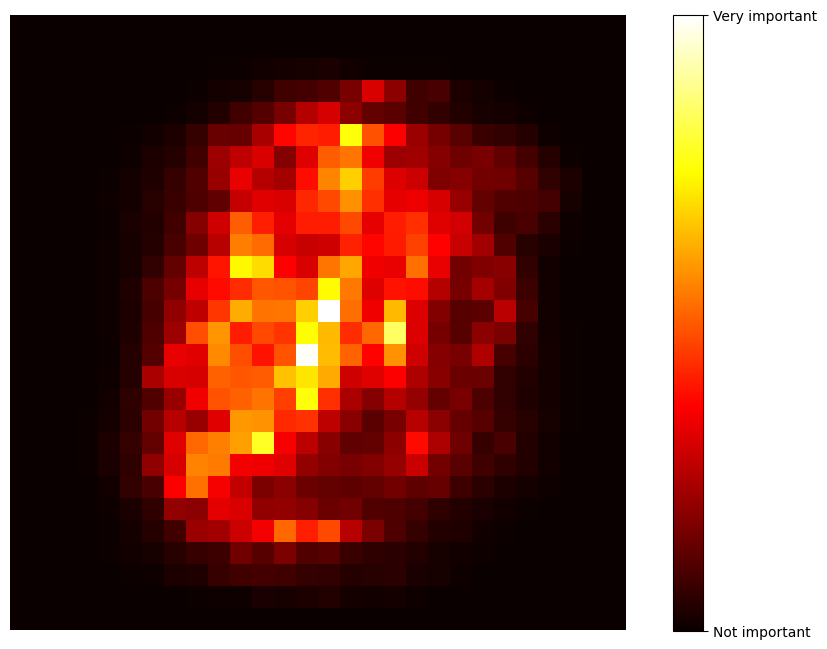

In [25]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## 7.5 Boosting

*Boosting* (originally called *hypothesis boosting* refers to any ensemble method that can combine several weak learners
into a strong learner.  But unlike the ensembles we looked at before, the general idea is to train predictors
sequentially, each trying to correct it predecessor.  There are many boosting methods, the most popular being
*AdaBoost* (short for *Adaptive Boosting*) and *Gradient Boosting*.

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to
the training instances that the predecessor underfitted. This results in new predictors
focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, when training an AdaBoost classifier, the algorithm first trains a base
classifier (such as a Decision Tree) and uses it to make predictions on the training set.
The algorithm then increases the relative weight of misclassified training instances.
Then it trains a second classifier, using the updated weights, and again makes
predictions on the training set, updates the instance weights, and so on.

The following example shows the decision boundaries of five consecutive predictors on the moons
dataset (in this example, each predictor is a highly regularized SVM classifier with an
RBF kernel). The first classifier gets many instances wrong, so their weights get
boosted. The second classifier therefore does a better job on these instances, and so on.

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

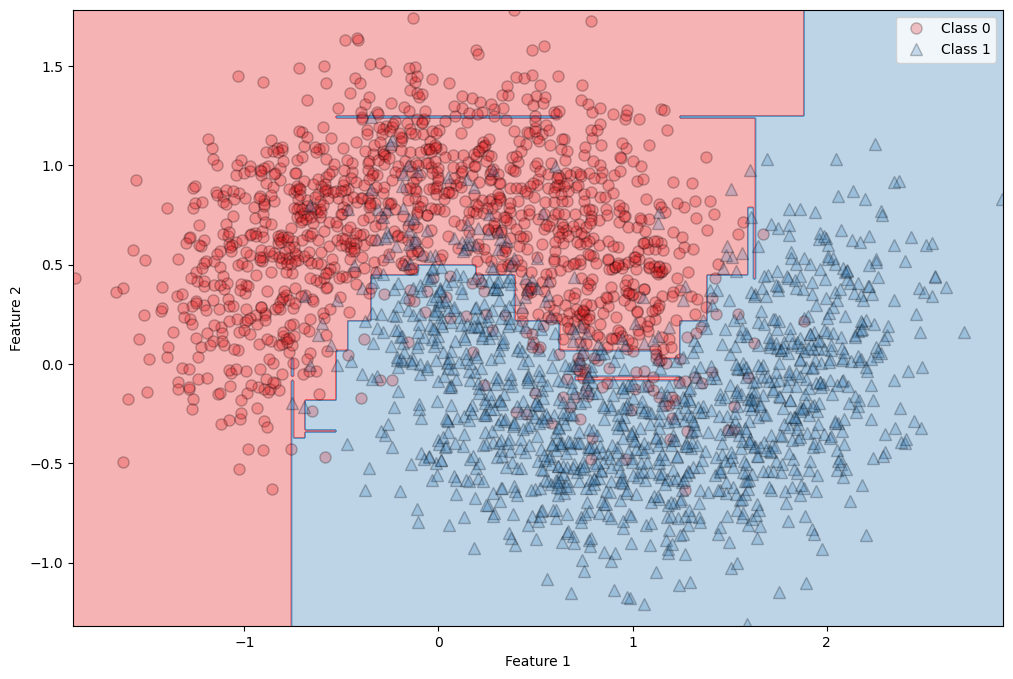

In [27]:
plot_multiclass_decision_boundaries(ada_clf, X, y)
plot_multiclass_data(X, y)

In [28]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.4)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

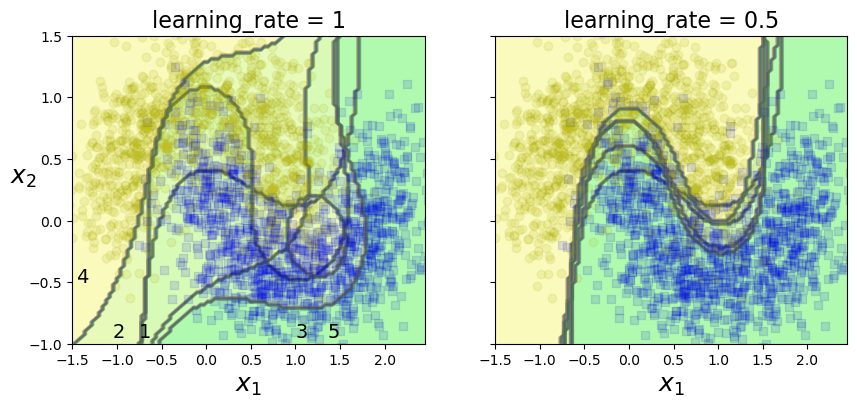

In [29]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.025)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")



The plot on the right represents the same sequence of predictors, except that the
learning rate is halved (i.e., the misclassified instance weights are boosted half as much
at every iteration). As you can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.

### Gradient Boosting

Another very popular boosting algorithm is Gradient Boosting. Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.

Let’s go through a simple regression example, using Decision Trees as the base
predictors.  This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First,
let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic
training set):

In [30]:
# create a simple quadratic dataset
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [31]:
# train a decision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we’ll train a second DecisionTreeRegressor on the residual errors made by the
first predictor:

In [32]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:

In [33]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [34]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

print(y_pred)

[0.75026781]


The next example represents the predictions of these three trees in the left column, and the
ensemble’s predictions in the right column. In the first row, the ensemble has just one
tree, so its predictions are exactly the same as the first tree’s predictions. In the second
row, a new tree is trained on the residual errors of the first tree. On the right you can see
that the ensemble’s predictions are equal to the sum of the predictions of the first two
trees. Similarly, in the third row another tree is trained on the residual errors of the
second tree. You can see that the ensemble’s predictions gradually get better as trees are
added to the ensemble.

In [35]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Text(0, 0.5, '$y$')

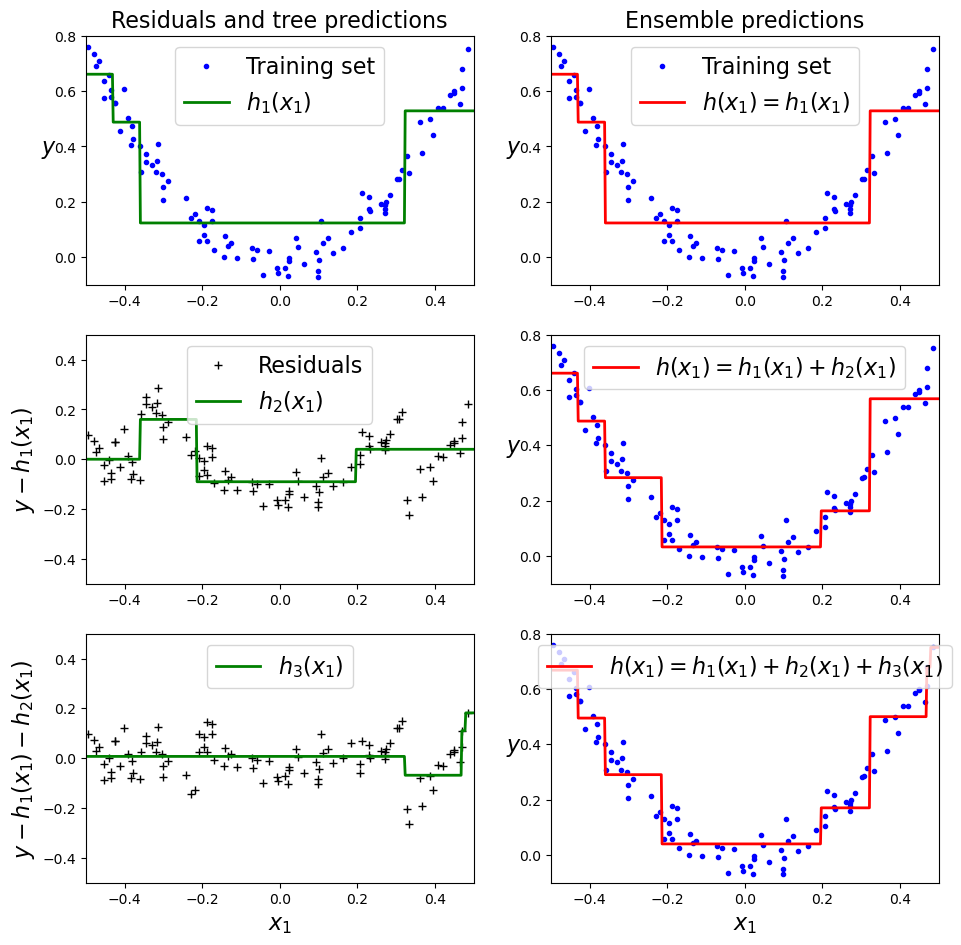

In [36]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

A simpler way to train GBRT ensembles is to use Scikit-Learn’s
GradientBoostingRegressor class. Much like the RandomForestRegressor class, it
has hyperparameters to control the growth of Decision Trees (e.g., `max_depth`,
`min_samples_leaf`), as well as hyperparameters to control the ensemble training, such
as the number of trees (n_estimators). The following code creates the same ensemble
as the previous one:

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

The `learning_rate` hyperparameter scales the contribution of each tree. If you set it to
a low value, such as 0.1, you will need more trees in the ensemble to fit the training set,
but the predictions will usually generalize better. This is a regularization technique
called shrinkage. The following example shows two GBRT ensembles trained with a low learning
rate: the one on the left does not have enough trees to fit the training set, while the one
on the right has too many trees and overfits the training set.

In [38]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Text(0.5, 0, '$x_1$')

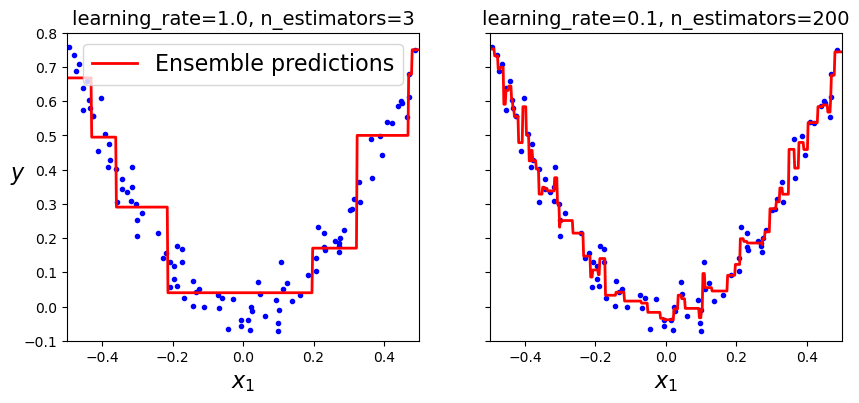

In [39]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

In order to find the optimal number of trees, you can use early stopping (see Chapter 4).
A simple way to implement this is to use the staged_predict() method: it returns an
iterator over the predictions made by the ensemble at each stage of training (with one
tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then
measures the validation error at each stage of training to find the optimal number of
trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

The validation errors are represented on the left of this figure, and the best model’s
predictions are represented on the right.

In [41]:
min_error = np.min(errors)

Text(0.5, 0, '$x_1$')

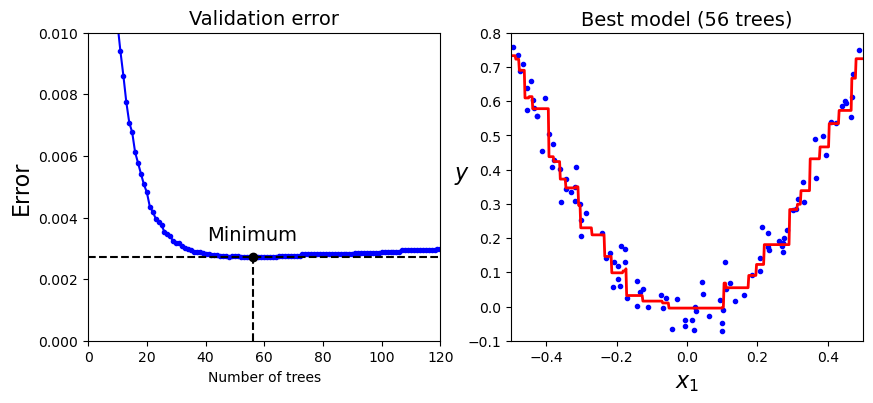

In [42]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). You can do so by setting warm_start=True, which makes Scikit-
Learn keep existing trees when the fit() method is called, allowing incremental
training. The following code stops training when the validation error does not improve
for five iterations in a row:

In [43]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [44]:
print(gbrt.n_estimators)

61


In [45]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


It is worth noting that an optimized implementation of Gradient Boosting is available in
the popular Python library XGBoost, which stands for Extreme Gradient Boosting. This
package was initially developed by Tianqi Chen as part of the Distributed (Deep)
Machine Learning Community (DMLC), and it aims to be extremely fast, scalable, and
portable. In fact, XGBoost is often an important component of the winning entries in
ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

May need to install this package:

```
$ conda install xgboost
```

In [47]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

XGBoost also offers several nice features, such as automatically taking care of early
stopping:

In [48]:
xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556


## 7.6 Stacking

Stacking works similar to the voting ensembles we have looked at.  Multiple independent classifiers are trained
in parallel and aggregrated.  But instead of using a trivial aggregration method (like hard voting), we train
yet another model to perform the aggregration.  This final model (called a *blender* or *meta learner*) takes
the other trained predictors's output as input and makes a final prediciton from them.  

'Scikit-learn' does not support stacking directly (unlike voting ensembles and boosting).  But it is not too difficult
to hand roll basic implementations of stacking from `scikit-learn` apis.